In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3
Thu Nov 16 10:10:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 30%   34C    P8     5W / 250W |      3MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ... 

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[10:10:21.270] INFO   CaloQVAE                                          Willkommen!
[10:10:21.273] INFO   CaloQVAE                                          Loading configuration.


In [3]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch/QVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2023-11-16 10:10:23,892 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[10:10:23.892] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [5]:
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[10:10:29.600] INFO   data.dataManager                                  Loading Data
[10:10:39.053] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3441652f40>: 80000 events, 625 batches
[10:10:39.055] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f34416520d0>: 10000 events, 10 batches
[10:10:39.056] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3441652310>: 10000 events, 10 batches
[10:10:44.548] INFO   models.modelCreator                               Initialising Model Type GumBoltCaloCRBMUnCond
2023-11-16 10:10:44,553 dwave.

40279 28582
Initializing NetworkV3


In [6]:


dev = torch.device("cuda:0")
wandb.watch(model)
engine=instantiate(config.engine, config)
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[10:11:01.002] INFO   wandb                                             Watching
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[10:11:02.880] INFO   engine.engineAtlas                                Setting up engine Atlas.
[10:11:02.881] INFO   engine.engineCaloV3                               Setting up engine Calo.
[10:11:02.882] INFO   engine.engine                                     Setting up default engine.


In [7]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[10:11:13.323] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3442d0a460>: 80000 events, 625 batches
[10:11:13.324] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f350a6e5d60>: 10000 events, 10 batches
[10:11:13.325] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f350a6e5d30>: 10000 events, 10 batches


In [8]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    #if module=="prior":
                        #print(checkpoint[module])
                        #print(checkpoint[module]['_weights'])
                        #print(checkpoint[module]['_visible_bias'])
                        #print(checkpoint[module]['_hidden_bias'])
                        #checkpoint[module]['_weights'] *= 0
                        #checkpoint[module]['_weights'] += 1e20
                        #checkpoint[module]['_visible_bias'] *= 0
                        #checkpoint[module]['_hidden_bias'] += 0.5
                        #print(checkpoint[module]['_weights'])
                        #print(checkpoint[module]['_visible_bias'])
                        #print(checkpoint[module]['_hidden_bias'])
                    getattr(model, module).load_state_dict(checkpoint[module])

In [10]:
#run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-10-30/10-30-17/wandb/run-20231030_103022-00s3l2jo/files/GumBoltAtlasCRBMCNNDCond_atlas_default_kl_off_end.pth"
run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-11-14/14-59-11/wandb/run-20231114_145917-ozaxomel/files/GumBoltCaloCRBMUnCond_atlas_default_best.pth"
modelname = 'dutiful-dragon-1388'
datascaled = 'scaled'
with open("/home/sgonzalez/CaloQVAE/outputs/2023-11-14/14-59-11/wandb/run-20231114_145917-ozaxomel/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltCaloCRBMUnCond
electron-ds2
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  sampler


In [11]:
xtarget_samples = []
xrecon_samples = []
xgen_samples = []
scaled = True
entarget_samples = []
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    
    fwd_output = engine.model((in_data, true_energy), False)
    
    if scaled:
        in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        
        
        recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        
        #Filter out large energies (MeV)
        total_energy = in_data.sum(dim=1)
        max_eng = 1e25
        keep = total_energy<max_eng
        in_data = in_data[keep]
        true_energy = true_energy[keep]
        recon_data = recon_data[keep]
        #print("sample_data before: ", sample_data.size(), torch.max(sample_data.sum(dim=1)))
        sample_total_energy = sample_data.sum(dim=1)
        keep = sample_total_energy<max_eng
        sample_data = sample_data[keep]
        #print("in_data: ", in_data.size(), torch.max(in_data.sum(dim=1)))
        #print("sample_data: ", sample_data.size(), torch.max(sample_data.sum(dim=1)))
        #break
    
    else:
        raise Exception("Script only supports scaled dataset at the moment...")


    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    entarget_samples.append(true_energy.detach().cpu())
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

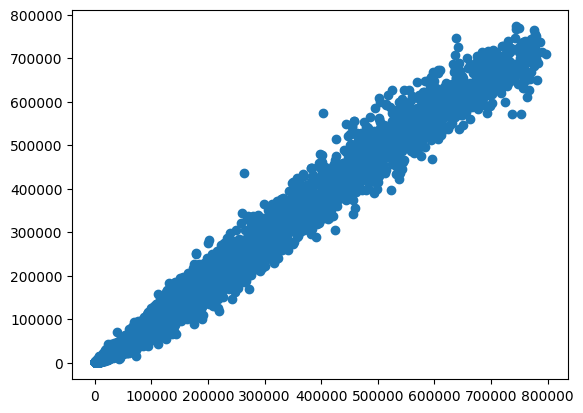

In [12]:
target_engs = xtarget_samples.sum(dim=1).numpy()
recon_engs = xrecon_samples.sum(dim=1).numpy()

plt.scatter(target_engs, recon_engs)

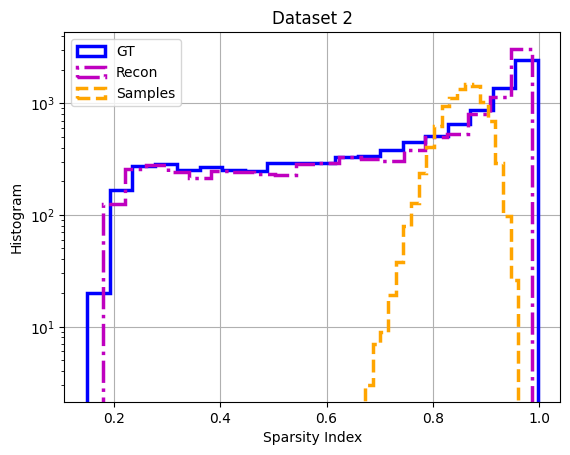

In [13]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2'}

plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples"])
plt.title(f'{ds[part]}')
plt.grid("True")
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

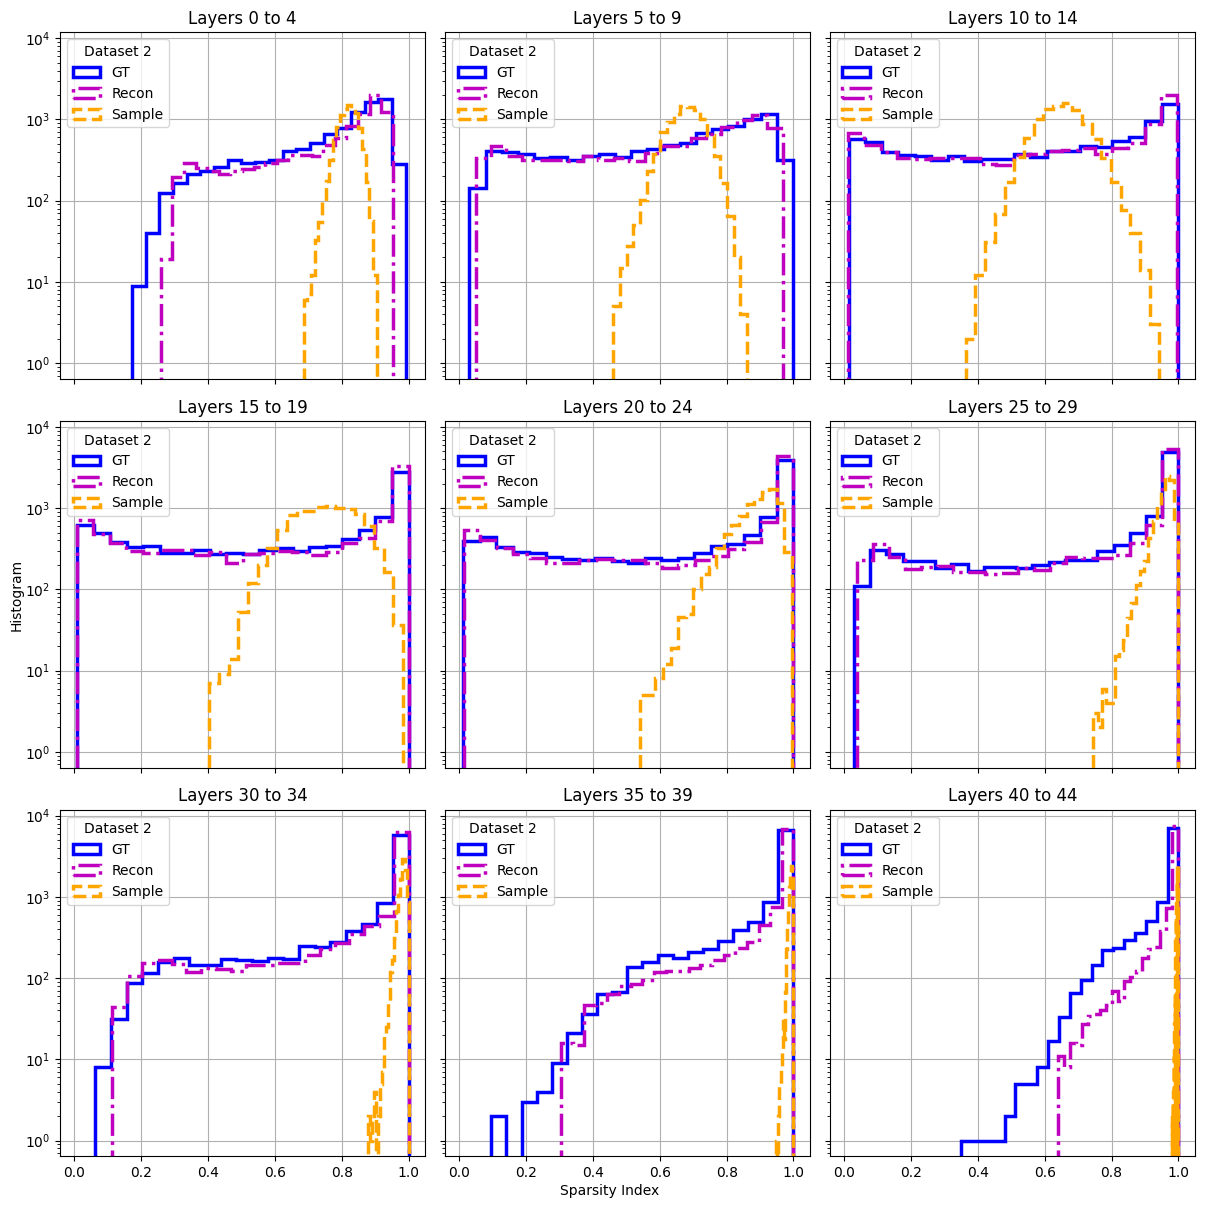

In [14]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, 0.0, 'Sparsity Index', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

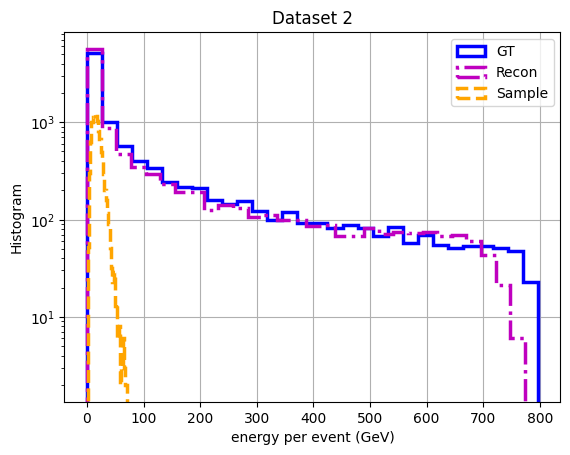

In [15]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample"])
plt.title(f'{ds[part]}')
plt.grid("True")
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

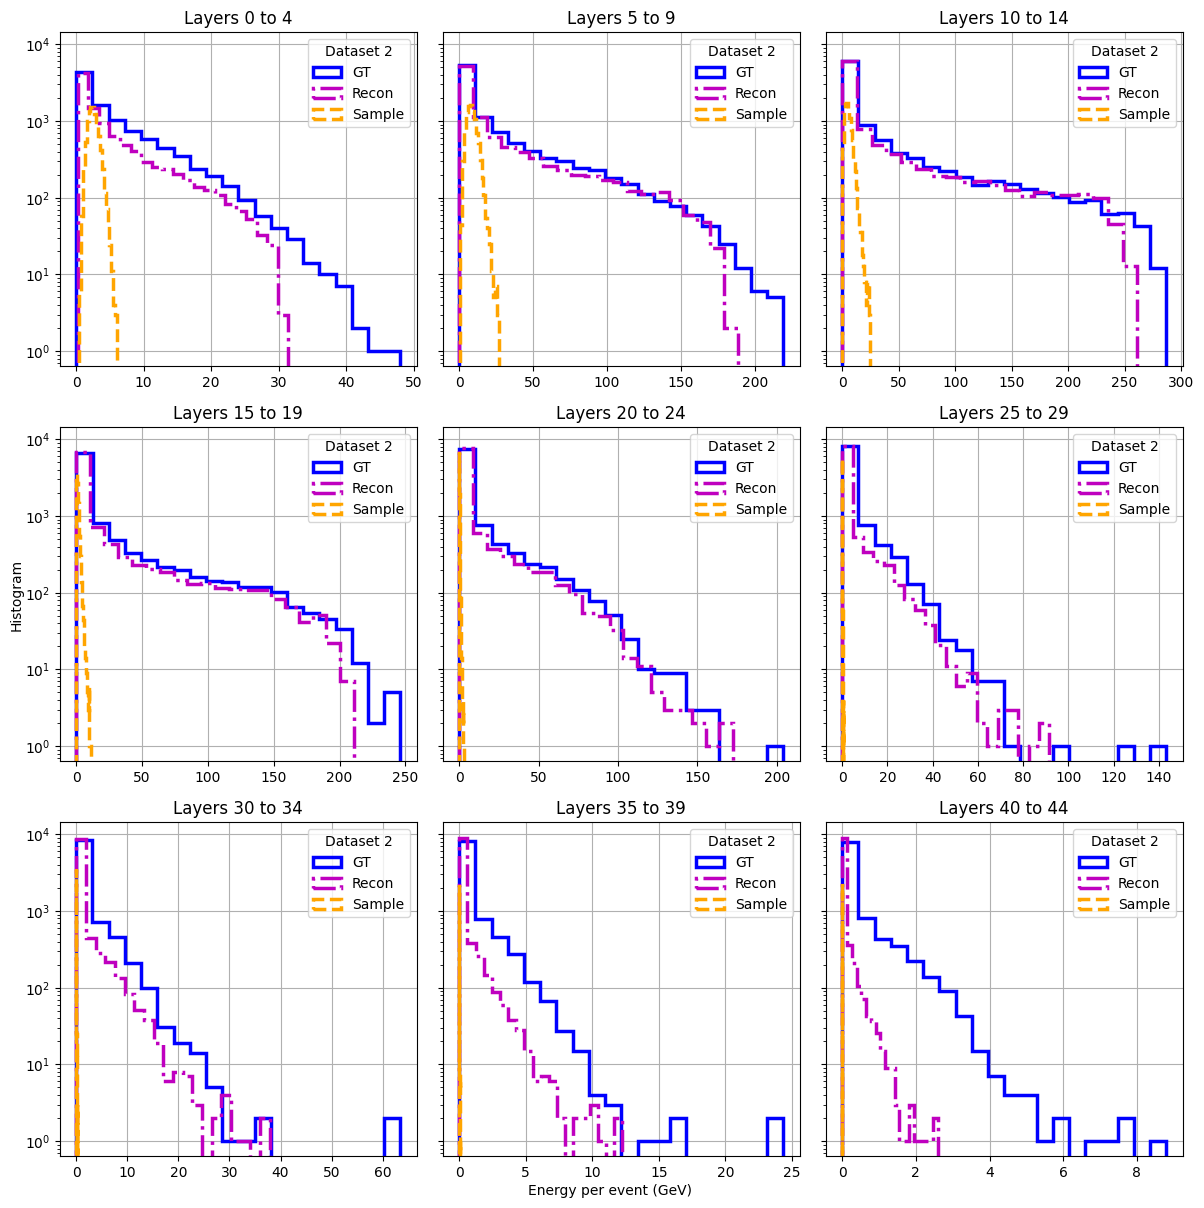

In [16]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [17]:
def energy_exp(rbm_vis, rbm_hid):
        w, vbias, hbias = engine._model.prior.weights, engine._model.prior.visible_bias, engine._model.prior.hidden_bias
        w = w.to(rbm_vis.device) # + torch.zeros((rbm_vis.size(0),) + w.size(), device=rbm_vis.device)
        vbias = vbias.to(rbm_vis.device)
        hbias = hbias.to(rbm_hid.device)
        
        vis = rbm_vis.unsqueeze(2).permute(0, 2, 1)
        hid = rbm_hid.unsqueeze(2)
        
        batch_energy = (- torch.matmul(vis, torch.matmul(w, hid)).reshape(-1)
                        - torch.matmul(rbm_vis, vbias)
                        - torch.matmul(rbm_hid, hbias))
        
        return batch_energy
    
def bad_energy_exp(rbm_vis, rbm_hid):
        w, vbias, hbias = engine._model.prior.weights, engine._model.prior.visible_bias, engine._model.prior.hidden_bias
        w = w.to(rbm_vis.device) * 0 + torch.randn((rbm_vis.size(0),) + w.size(), device=rbm_vis.device)*0.1
        vbias = vbias.to(rbm_vis.device)*0
        hbias = hbias.to(rbm_hid.device)*0
        
        vis = rbm_vis.unsqueeze(2).permute(0, 2, 1)
        hid = rbm_hid.unsqueeze(2)
        
        batch_energy = (- torch.matmul(vis, torch.matmul(w, hid)).reshape(-1)
                        - torch.matmul(rbm_vis, vbias)
                        - torch.matmul(rbm_hid, hbias))
        
        return batch_energy

In [18]:

energies = []
bad_energies = []
num_iter_samples = 100

for i in range(num_iter_samples):
    rbm_vis, rbm_hid = engine._model.sampler.block_gibbs_sampling()
    energy_samples = energy_exp(rbm_vis, rbm_hid)
    bad_energy_samples = bad_energy_exp(rbm_vis, rbm_hid)
    
    energies.append(energy_samples)
    bad_energies.append(bad_energy_samples)
energies_prior = torch.cat(energies, dim=0)
bad_energies_prior = torch.cat(bad_energies, dim=0)


In [19]:
xapprox_post_samples = []
energies = []

scaled = True
with torch.no_grad():
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        #in_data = torch.cat([in_data, true_energy], dim=1)
        
        _, _, post_samples = engine.model.encoder(in_data, False)
        rbm_vis = post_samples[0].detach().cpu()
        rbm_hid = post_samples[1].detach().cpu()

        energy_samples = energy_exp(rbm_vis, rbm_hid)
        energies.append(energy_samples)
        


    energies_post = torch.cat(energies, dim=0)

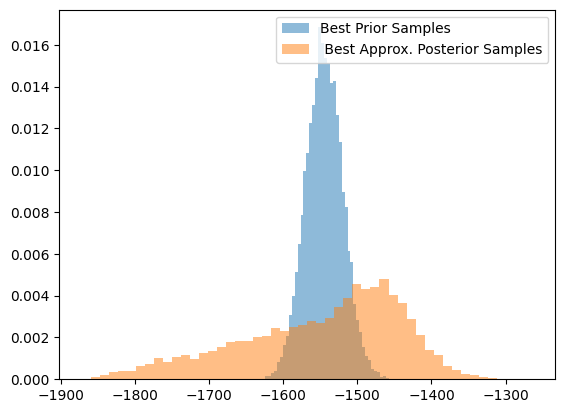

In [20]:
plt.hist(energies_prior.detach().cpu().numpy(), bins=50, alpha=0.5, density=True, label="Best Prior Samples")
#plt.hist(bad_energies_prior.detach().cpu().numpy(), bins=50, alpha=0.5, density=True, label="Random Prior Samples")
plt.hist(energies_post.detach().cpu().numpy(), bins=50, alpha=0.5, density=True, label=" Best Approx. Posterior Samples")
plt.legend()